# Diagnóstico de Diabetes
Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo es predecir, a partir de mediciones diagnósticas, si un paciente tiene diabetes.ase (0 o 1)

## Contenido
Se impusieron varias restricciones a la selección de estas instancias de una base de datos más grande. En particular, todos los pacientes aquí son mujeres de al menos 21 años de edad de ascendencia indígena Pima.

- Embarazos: Número de veces embarazadas
- Glucosa: Concentración de glucosa plasmática a 2 horas en una prueba de tolerancia oral a la glucosa
- Presión arterial: Presión arterial diastólica (mm Hg)
- Grosor de la piel: Grosor del pliegue cutáneo del tríceps (mm)
- Insulina: Insulina sérica de 2 horas (mu U/ml)
- IMC: Índice de masa corporal (peso en kg/(altura en m)^2)
- DiabetesPedigríFunción: Función del pedigrí de la diabetes
- Edad: Edad (años)
- Resultado: Variable de clase (0 o 1)

In [18]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import itertools

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [20]:
data = pd.read_csv('diabetes.csv')
print(f"shape: {data.shape}")
data.head()

shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Visualización del Datashet

In [21]:
df = pd.DataFrame(data)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 3. Preparación del datasheet

In [23]:
df.isnull().sum().to_frame('NaN value').T

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
NaN value,0,0,0,0,0,0,0,0,0


In [24]:
for col in df:
    print(f"{col}: {df[col].nunique()}")

Pregnancies: 17
Glucose: 136
BloodPressure: 47
SkinThickness: 51
Insulin: 186
BMI: 248
DiabetesPedigreeFunction: 517
Age: 52
Outcome: 2


In [25]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [26]:
df_sorted = df.sort_values(by="Outcome", ascending=True)
df_sorted

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
383,1,90,62,18,59,25.1,1.268,25,0
465,0,124,56,13,105,21.8,0.452,21,0
466,0,74,52,10,36,27.8,0.269,22,0
467,0,97,64,36,100,36.8,0.600,25,0
469,6,154,78,41,140,46.1,0.571,27,0
...,...,...,...,...,...,...,...,...,...
193,11,135,0,0,0,52.3,0.578,40,1
485,0,135,68,42,250,42.3,0.365,24,1
484,0,145,0,0,0,44.2,0.630,31,1
186,8,181,68,36,495,30.1,0.615,60,1


In [27]:
df_no_diabetes = df[df["Outcome"] == 0]  # Casos sin diabetes
df_diabetes = df[df["Outcome"] == 1]  # Casos con diabetes

In [28]:
df_no_diabetes.head()  # Muestra los primeros casos sin diabetes
df_diabetes.head()  # Muestra los primeros casos con diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
2,8,183,64,0,0,23.3,0.672,32,1
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1


In [29]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

### 4.Analisis Exploratorio de Datos (EDA)

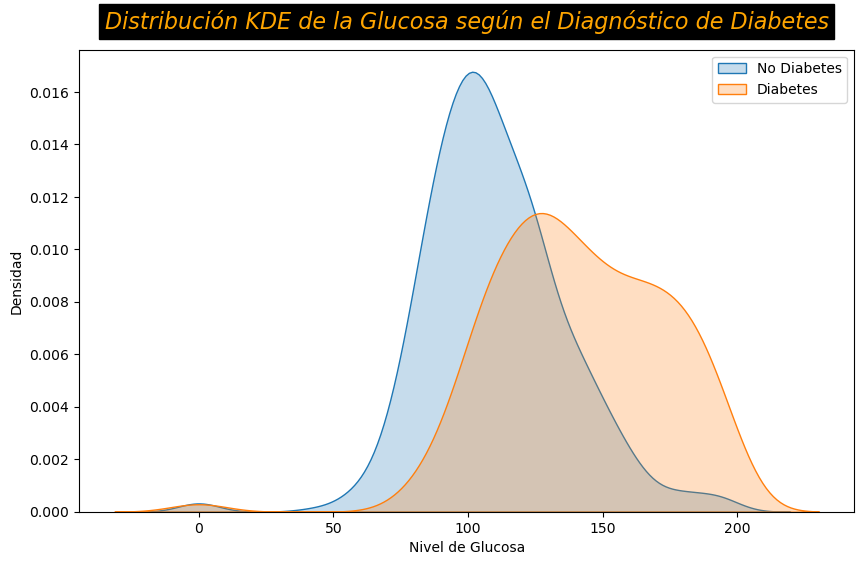

In [32]:
# Ignorar advertencias de FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuración del estilo del gráfico
font = {'fontsize': 16, 'fontstyle': 'italic', 'backgroundcolor': 'black', 'color': 'orange'}

# Activar gráficos en línea en Jupyter Notebook
%matplotlib inline

# Gráfico KDE para visualizar la distribución de glucosa según la presencia de diabetes
plt.figure(figsize=(10,6))
sns.kdeplot(df.loc[df['Outcome'] == 0, 'Glucose'], label='No Diabetes', fill=True)
sns.kdeplot(df.loc[df['Outcome'] == 1, 'Glucose'], label='Diabetes', fill=True)

# Configuración del título y etiquetas
plt.title('Distribución KDE de la Glucosa según el Diagnóstico de Diabetes', fontdict=font, pad=15)
plt.xlabel('Nivel de Glucosa')
plt.ylabel('Densidad')
plt.legend()
plt.show()

### 4.1. Analisis univariable

C:\Users\artev\AppData\Local\Temp\ipykernel_17520\1492229169.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



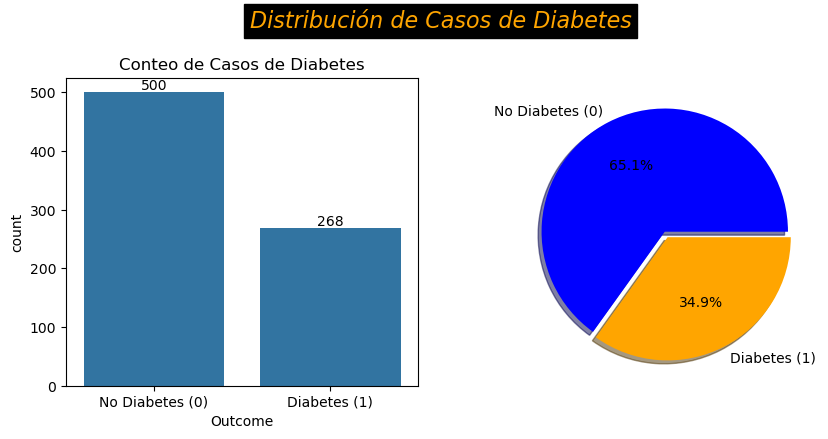

In [32]:
# Ignorar advertencias
warnings.filterwarnings("ignore", category=FutureWarning)
# Configuración del estilo del gráfico
font = {'fontsize': 16, 'fontstyle': 'italic', 'backgroundcolor': 'black', 'color': 'orange'}
# Activar gráficos en línea en Jupyter Notebook
%matplotlib inline
# Crear la figura con 2 subgráficos
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de barras del conteo de pacientes con y sin diabetes
sns.countplot(data=df, x='Outcome', ax=axes[0])
axes[0].set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])
axes[0].set_title('Conteo de Casos de Diabetes')

# Etiquetas en las barras
for container in axes[0].containers:
    axes[0].bar_label(container)

# Gráfico de pastel con la proporción de casos
slices = df.Outcome.value_counts().values
labels = ['No Diabetes (0)', 'Diabetes (1)']
axes[1].pie(slices, labels=labels, colors=['blue', 'orange'], shadow=True, 
            explode=[0, 0.05], autopct='%1.1f%%')

# Título general del gráfico
plt.suptitle('Distribución de Casos de Diabetes', y=1.05, **font)

# Mostrar la visualización
plt.show()

### 4.2. Analisis Bivariable

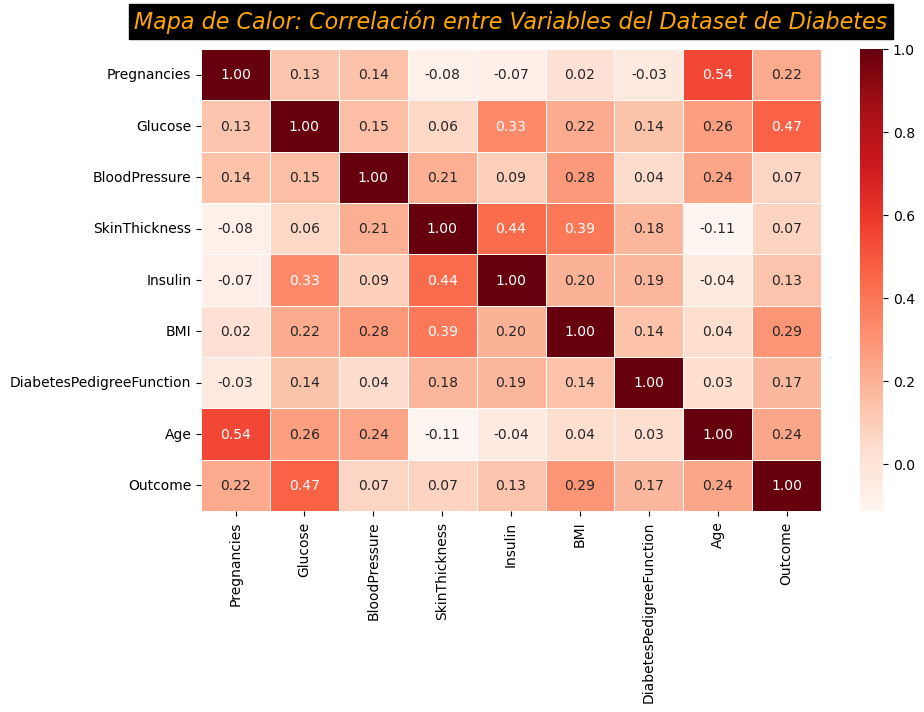

In [33]:
# Ignorar advertencias
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuración del estilo del título
font = {'fontsize': 16, 'fontstyle': 'italic', 'backgroundcolor': 'black', 'color': 'orange'}

# Activar gráficos en línea en Jupyter Notebook
%matplotlib inline

# Configurar tamaño de la figura
plt.figure(figsize=(10, 6))

# Generar el heatmap de correlaciones
sns.heatmap(df.corr(), cmap='Reds', annot=True, fmt=".2f", linewidths=0.5)

# Título del gráfico
plt.title('Mapa de Calor: Correlación entre Variables del Dataset de Diabetes', pad=15, **font)

# Mostrar el gráfico
plt.show()
